# ANZ virtual internship 
## Building a salary predicting model

Using the same transaction dataset, identify the annual salary for each customer

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

# Import libraries and data

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
%matplotlib inline

In [292]:
df = pd.read_excel('clean_anz.xlsx')
df.head(2)

,status,card_present_flag,account,currency,txn_description,merchant_id,first_name,balance,gender,age,...,merchant_long_lat,movement,date,month,weekday,day,time,hour,c_long,c_lat
0,authorized,1.0,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,F,26,...,153.38 -27.99,debit,2018-08-01,8,2,1,01:01:15,1,153.41,-27.95
1,authorized,0.0,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,F,26,...,151.21 -33.87,debit,2018-08-01,8,2,1,01:13:45,1,153.41,-27.95


## Feature engineering

- age in categories, below20, btw20n40, btw40n60, 60+

#### State of customers

In [126]:
# count number of transactions per customer per state
state_df = df.groupby(['customer_id', 'merchant_state']).count()

In [365]:
state_df['transaction_id']

customer_id     merchant_state
CUS-1005756958  NSW                9
                QLD               39
CUS-1117979751  NSW                9
                SA                 2
                VIC                2
                                  ..
CUS-883482547   NSW               96
                QLD                3
                SA                 4
                VIC                5
                WA                12
Name: transaction_id, Length: 408, dtype: int64

In [356]:
state_df['transaction_id'].sort_values(ascending=False)

customer_id     merchant_state
CUS-2487424745  QLD               444
CUS-2142601169  NSW               227
CUS-3026014945  WA                191
CUS-1614226872  QLD               185
CUS-860700529   QLD               173
                                 ... 
CUS-2370108457  NSW                 1
CUS-51506836    SA                  1
CUS-2348881191  SA                  1
                QLD                 1
CUS-261674136   SA                  1
Name: transaction_id, Length: 408, dtype: int64

In [350]:
max_state = state_df['transaction_id'].groupby('customer_id').max()

In [351]:
max_state

customer_id
CUS-1005756958     39
CUS-1117979751     39
CUS-1140341822     55
CUS-1147642491     61
CUS-1196156254     59
                 ... 
CUS-72755508       41
CUS-809013380      56
CUS-860700529     173
CUS-880898248      49
CUS-883482547      96
Name: transaction_id, Length: 99, dtype: int64

In [228]:
state_df.index

MultiIndex([('CUS-1005756958', 'NSW'),
            ('CUS-1005756958', 'QLD'),
            ('CUS-1117979751', 'NSW'),
            ('CUS-1117979751',  'SA'),
            ('CUS-1117979751', 'VIC'),
            ('CUS-1117979751',  'WA'),
            ('CUS-1140341822', 'NSW'),
            ('CUS-1140341822', 'QLD'),
            ('CUS-1140341822',  'SA'),
            ('CUS-1140341822', 'VIC'),
            ...
            ( 'CUS-860700529',  'WA'),
            ( 'CUS-880898248', 'ACT'),
            ( 'CUS-880898248', 'NSW'),
            ( 'CUS-880898248',  'SA'),
            ( 'CUS-880898248', 'VIC'),
            ( 'CUS-883482547', 'NSW'),
            ( 'CUS-883482547', 'QLD'),
            ( 'CUS-883482547',  'SA'),
            ( 'CUS-883482547', 'VIC'),
            ( 'CUS-883482547',  'WA')],
           names=['customer_id', 'merchant_state'], length=408)

In [216]:
state_df.index[0][1]

'NSW'

In [258]:
state_df.loc['CUS-1005756958']['transaction_id']

merchant_state
NSW     9
QLD    39
Name: transaction_id, dtype: int64

#### Annual salary for each customer

In [293]:
# make a new dataframe with only salary payments
df_salaries = df[df['txn_description']=='PAY/SALARY'].groupby('customer_id').sum()

In [294]:
# divide the sum of each customer's salary payment with 3 to get an average monthly pay 
# and then multiply with 12 to get an annual salary
annual_salaries = df_salaries['amount']/3*12 # annual salary for each customer

In [295]:
annual_salaries.loc['CUS-1005756958']

50464.44

In [296]:
# match every customer_id with their calculated annual salary
salaries = []

for i in df['customer_id']:
    salaries.append(int(annual_salaries.loc[i]))
    
df['annual_salary'] = salaries

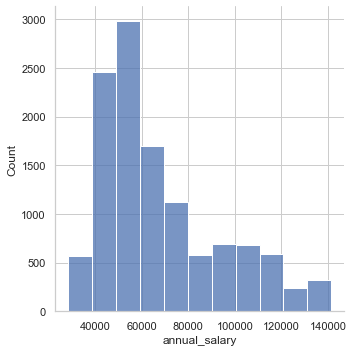

In [297]:
# skewed distribution
sns.displot(df['annual_salary'], bins=11);

### POS or SALES-POS purchase transactions

In [298]:
# 'POS' + 'SALES-POS' VS rest of transactions
pos_df = df[(df['txn_description']=='POS') | (df['txn_description']=='SALES-POS')]

#### Number of transactions per week

In [299]:
# count number of transactions per customer
pos_trans_df = pos_df.groupby('customer_id').count()

In [300]:
# average number of transactions per week for customer
weekly_trans = round(pos_trans_df['transaction_id']/7, 0)

In [301]:
# average number of transactions per week for customer
avg_weekly_trans_num = []

for i in df['customer_id']:
    avg_weekly_trans_num.append(int(weekly_trans.loc[i]))
    
df['avg_weekly_trans_num'] = avg_weekly_trans_num

#### Purchase transaction days

In [302]:
# number of days with transactions per customer. Do they make purchases every day?
pos_df[pos_df['customer_id']=='CUS-809013380']['date'].nunique()

29

In [303]:
no_trans_days = []

for i in df['customer_id']:
    no_trans_days.append(pos_df[pos_df['customer_id']==i]['date'].nunique())

In [304]:
df['no_trans_days'] = no_trans_days

#### Average purchase amount

In [305]:
int(round(pos_df[pos_df['customer_id']=='CUS-809013380']['amount'].mean(), 0))

27

In [306]:
avg_trans_amount = []

for i in df['customer_id']:
    avg_trans_amount.append(int(round(pos_df[pos_df['customer_id']==i]['amount'].mean(), 0)))

In [307]:
df['avg_trans_amount'] = avg_trans_amount

#### Max purchase amount

In [308]:
round(pos_df[pos_df['customer_id']=='CUS-809013380']['amount'].max(), 1)

377.8

In [309]:
max_amount = []

for i in df['customer_id']:
    max_amount.append(round(pos_df[pos_df['customer_id']==i]['amount'].max(), 1))

In [310]:
df['max_amount'] = max_amount

#### Number of large transactions 

In [311]:
pos_df[(pos_df['customer_id']=='CUS-2178051368') & (pos_df['amount']>100)]['amount'].count()

1

In [312]:
num_large_trans = []

for i in df['customer_id']:
    num_large_trans.append(pos_df[(pos_df['customer_id']==i) & (pos_df['amount']>100)]['amount'].count())

In [313]:
df['num_large_trans'] = num_large_trans

#### Average balance

In [314]:
df[df['customer_id']=='CUS-809013380']['balance'].median()

3123.7749999999996

In [315]:
med_balance = []

for i in df['customer_id']:
    med_balance.append(df[df['customer_id']==i]['balance'].median())

In [316]:
df['med_balance'] = med_balance

### Encoding categorical features

In [317]:
cat_feats = df[['status', 'txn_description', 'gender']]

In [318]:
cat_feats = pd.get_dummies(cat_feats, drop_first=True)
cat_feats.head(2)

,status_posted,txn_description_PAY/SALARY,txn_description_PAYMENT,txn_description_PHONE BANK,txn_description_POS,txn_description_SALES-POS,gender_M
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0


In [324]:
num_feats = df[['balance', 'age', 'amount', 'annual_salary', 'avg_weekly_trans_num', 'no_trans_days',
       'avg_trans_amount', 'max_amount', 'num_large_trans', 'med_balance']]
num_feats.head(3)

,balance,age,amount,annual_salary,avg_weekly_trans_num,no_trans_days,avg_trans_amount,max_amount,num_large_trans,med_balance
0,35.39,26,16.25,56765,76,82,18,1452.2,4,1580.40
1,21.20,26,14.19,56765,76,82,18,1452.2,4,1580.40
2,5.71,38,6.42,52110,39,70,35,2349.6,7,1132.66


## Check correlation

In [325]:
num_feats.corr()['annual_salary'].sort_values(ascending=False)

annual_salary           1.000000
med_balance             0.258076
balance                 0.257159
amount                  0.091111
avg_trans_amount        0.044312
age                     0.035041
num_large_trans        -0.045275
max_amount             -0.097739
no_trans_days          -0.172765
avg_weekly_trans_num   -0.189532
Name: annual_salary, dtype: float64

### Scale numerical features

In [269]:
from sklearn.preprocessing import MinMaxScaler

In [326]:
num_feats = num_feats.drop('annual_salary', axis=1)

In [327]:
scaler_x = MinMaxScaler()
num_feats_scaled = scaler_x.fit_transform(num_feats)

salary = df['annual_salary'].values.reshape(-1, 1)
scaler_y = MinMaxScaler()
salary_scaled = scaler_y.fit_transform(salary)

In [328]:
# get column names
scaled_num_df = pd.DataFrame(data = num_feats_scaled, columns = num_feats.columns, index = num_feats.index)
# Pass the index of index df_merged_num, otherwise it will sum up the index.

In [329]:
scaled_y = pd.DataFrame(data = salary_scaled, columns = ['annual_salary'], index = num_feats.index)

In [330]:
# merge model features to one dataframe
frames = [scaled_num_df, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [331]:
X = model_feats
y = scaled_y

In [332]:
from sklearn.model_selection import train_test_split

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Creating a  Linear Regression Model

In [334]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, r2_score

In [336]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [337]:
preds_lm = lm.predict(X_test)

### Valuating the model

In [338]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [339]:
print('R-squared', r2_score(y_test, preds_lm)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, preds_lm))
print('MSE:', metrics.mean_squared_error(y_test, preds_lm))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds_lm))) # directly comparable witht data, $

R-squared 0.13307711780203635
MAE: 0.17025126366426996
MSE: 0.047798910781366014
RMSE: 0.21862962009152834


In [340]:
preds_lm

array([[0.29426713],
       [0.39121729],
       [0.26781504],
       ...,
       [0.307985  ],
       [0.33788947],
       [0.26760741]])

In [341]:
y_test

,annual_salary
5673,0.131111
8859,0.363337
2891,0.208307
3513,0.451442
8496,0.271986
...,...
2262,0.253308
3214,0.224422
9610,0.154082
5783,0.651403


In [342]:
preds_lm = scaler_y.inverse_transform(preds_lm)
y_test = scaler_y.inverse_transform(y_test)

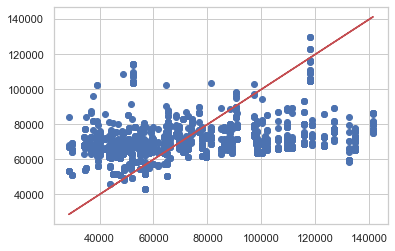

In [343]:
# Our predictions
plt.scatter(y_test, preds_lm)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [344]:
# Test data real sale price dataframe
test_salary_df = pd.DataFrame(y_test, columns=['Test Y'])

# Predicted prices dataframe
preds_reshape = pd.Series(preds_lm.reshape(3576,))
preds = pd.DataFrame(preds_reshape, columns = ['Predicted'])

# Merge real price and predicted price dataframes
compare_salary_df = pd.merge(test_salary_df, preds, how = 'inner', left_index = True, right_index = True)
compare_salary_df.head(5)

,Test Y,Predicted
0,43406.0,61802.207990
1,69590.0,72733.532333
2,52110.0,58819.681030
3,79524.0,62051.526983
4,59290.0,72796.461450


In [345]:
# Add a new column with error in prediction compared
compare_salary_df['Error'] = compare_salary_df['Test Y'] - compare_salary_df['Predicted']

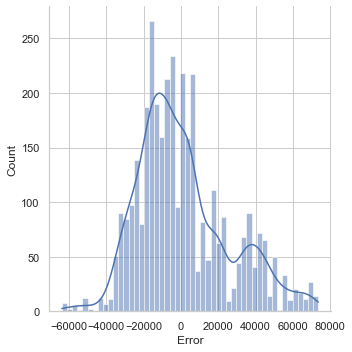

In [346]:
sns.displot(compare_salary_df['Error'], bins = 50, kde = True)

## Creating a Decision Tree model